# Decode EEG Analysis

## Step 1: Exploring the Data
Like with any project, we'll first import all the libraries/packages we're going to use. Note that I added to this list as I was writing the analysis.

In [ ]:
from scipy import fft, signal
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn.linear_model as lm
import sklearn.model_selection as ms
from sklearn import svm, metrics, model_selection, naive_bayes, decomposition, neural_network, preprocessing

Now we'll import the data, using the Pandas library, and check to make sure it looks good. If you want to visualize the data, you can play around with the middle block of code below.

Peek at the data:

    SubjectID  VideoID  Attention  ...   Gamma2  predefinedlabel  user-definedlabeln
0        0.0      0.0       56.0  ...   8293.0              0.0                 0.0
1        0.0      0.0       40.0  ...   2740.0              0.0                 0.0
2        0.0      0.0       47.0  ...  25354.0              0.0                 0.0
3        0.0      0.0       47.0  ...  33932.0              0.0                 0.0
4        0.0      0.0       44.0  ...  29749.0              0.0                 0.0

[5 rows x 15 columns]

Plot of Selected Data:


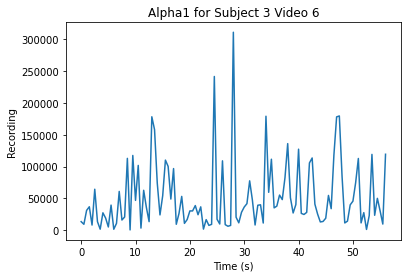

In [ ]:
# Import the data using the pandas library, and take a peek to make sure it loaded properly
raw_data = pd.read_csv(r"/content/drive/MyDrive/AA/EEG_data.csv")
print("Peek at the data:\n\n",raw_data.head())

# Choose the SubjectID, VideoID, and recording you want to plot:
subject_id = 3
video_id = 6
recording_type = "Alpha1"

# Code for plotting
print("\nPlot of Selected Data:")
data = raw_data[(raw_data["SubjectID"]==subject_id) & (raw_data["VideoID"]==video_id)][recording_type]
times = np.arange(0, len(data)/2, 0.5)
plt.plot(times, data)
plt.title(f"{recording_type} for Subject {subject_id} Video {video_id}")
plt.xlabel("Time (s)")
plt.ylabel("Recording")
plt.show()

The format of this data is that SubjectID goes 1-10, and for each SubjectID we have 1-10 for VideoID. Througout this analysis, we'll want an easy way to get the data relating to a specific participant, and specific video. We can make a function to do that:

In [ ]:
def get_rows(participant_id, video_id, raw_data=raw_data):
  index = (raw_data["SubjectID"]==participant_id) & (raw_data["VideoID"]==video_id)
  return pd.DataFrame(raw_data[index])

Finally, it's important to note that some columns in our dataset above contain some really large values. Specifically, the way that NeuroSky reports band power uses an exponential scale. Before we do any analysis with it, it would be good to make a mental note that we should take the logarithm of the values in these columns to make them more manageable.

## Step 2: Setting up for Machine Learning

### A Brief Intro to ML
Machine learning is a method used for extracting meaningful information from large amounts of data. To do this, we used programs called "Machine Learning Algorithms", which basically each have their own way of extracting information from our data.

Often times, we use machine learning to classify things. The algorithms that carry out this type of ML are called classifiers. For example, you might try to create a classifier that given a picture of an animal, it will try to classify that animal as either a cat or a turtle. To do this, the classifier needs to know what characteristics are associated with the categories "turtle" and "cat". These characteristics are called "features", and you as the human have to decide what features will help your classifier tell the difference between the different "labels"/categories. 

With the cat vs. turtle example, a good feature to give your algorithm would be whether the animal in question has a shell, since this is highly indicative of a turtle. A bad feature would be the number of legs it has, since turtles and cats both have 4 legs. 

An algorithm learns which features are associated with which labels through the process of "training". Usually, we train our algorithms by showing them a bunch of labelled pictures, some labelled "cat", and others labelled "turtle". By showing these labelled images, the algorithm will "learn" that fur and whiskers are associated with cats, while shells are associated with turtles.

Finally, we can check how well our classifier works by asking it to classify animals that we know are either turtles or cats. One common score to use is accuracy, which is asking how many of the examples the classifier got right.



Below, we have a function that can take the features and labels of our data, and then automatically try out a few different classifiers and tell us how well we can predict the confusion level. This function is in the cell below.

In [ ]:
def test_classification(features, labels, n_splits=5, prints=True):
  # Create our models, and possible hyperparameter values for tuning
  params = {"SVM": {"C":np.linspace(0.01,2,10)}}
  models = {"SVM":ms.GridSearchCV(svm.SVC(), params["SVM"]), 
            "NB":naive_bayes.GaussianNB(),
            "LR":lm.LogisticRegression()}
  # Dictionaries to save our AUC and accuracy scores for each model
  model_auc = {model_name:0 for model_name in models.keys()}
  model_acc = {model_name:0 for model_name in models.keys()}
  # K-fold cross-validation to see how the model performs
  splitter = model_selection.KFold(n_splits=n_splits, shuffle=True)
  for train_index, test_index in splitter.split(features):
    x_train, x_test = features[train_index], features[test_index]
    y_train, y_test = labels[train_index], labels[test_index]
    # Scale the training and testing features separately so testing is reliable
    x_train, x_test = preprocessing.scale(x_train), preprocessing.scale(x_test)
    # Fit each model with the train set, and find accuracy and AUC on the test set
    for model_name, model in models.items():
      model.fit(x_train, y_train)
      y_predicted = model.predict(x_test)
      model_auc[model_name] += metrics.roc_auc_score(y_test, y_predicted)
      model_acc[model_name] += metrics.accuracy_score(y_test, y_predicted)
  # Get the average AUC and accuracy over all the splits
  model_auc = {model_name:model_score/n_splits for model_name, model_score in model_auc.items()}
  model_acc = {model_name:model_score/n_splits for model_name, model_score in model_acc.items()}
  # Print the AUC and accuracy if requested
  if prints:
    print("AUC")
    for model_name, model_score in model_auc.items():
      print(f"{model_name}: {model_score}")
    print()
    print("Accuracy")
    for model_name, model_score in model_acc.items():
      print(f"{model_name}: {model_score}")
  # Output the AUC and accuracy for each model
  return model_auc, model_acc

The cell above contains all the machine learning we'll need to do to analyze our data. In it, we use the sklearn library to set up a couple different classifiers:

1. Support Vector Machine (SVM)
2. Naive Bayes (NB)
3. Logistic Regression (LR)
There are a lot of other ones we could have chosen, but these are the most common (also some of the simplest) ones. It's good to give these a try before anything else.

To make sure we also get a fair representation for how each classifier works, we'll use a 75%-25% train-test split for our data. This means that we train our models on 75% of our data points, and then test how well it classifies on the remaining 25%. We do this 4 times, using a different 25% each time for the test data. This is called 4-fold cross-validation.

Finally, we'll gauge how well our classifier works using accuracy:

Accuracy: Of the times our classifier said someone was confused, how many times were they actually confused.

## Initial Ideas

We start off by doing some literature searching to find out what EEG signals are correlated with confusion level. That's going to inform the analysis procedure we use.

One approach that works well sometimes is to simply look at the mean and variance of the signal in cases where someone was confused, and compare it to when they were not confused. We'll try using this approach below.

In [ ]:
overall_aucs = {"SVM":[], "NB":[], "LR":[]}
overall_accs = {"SVM":[], "NB":[], "LR":[]}
for i in range(20):  
  # Get the IDs for the participants, and the videos they were showed
  participant_ids = list(set(raw_data["SubjectID"]))
  video_ids = list(set(raw_data["VideoID"]))

  # Column names in our dataset
  freq_bands = ("Alpha1", "Alpha2", "Beta1", "Beta2", "Gamma1", 
                "Gamma2", "Delta", "Theta", "Raw", "Attention", 
                "Mediation")

  # Compute the features & labels
  features = []
  labels = []
  for participant_id in participant_ids:
    for video_id in video_ids:
      # Get the rows that correspond to this subject and movie
      data = get_rows(participant_id, video_id)
      # Initialize the list of features for this sample
      f = []
      # Get the features from each frequency band
      for freq_band in freq_bands:
        if freq_band not in ("Raw", "Attention", "Mediation"):
          mean_log = np.mean(np.log(data[freq_band]))
          mean_var = np.std(np.log(data[freq_band]))
          f.append(mean_log)
          f.append(mean_var)
        else:
          mean = np.mean(data[freq_band])
          var = np.std(data[freq_band])
          f.append(mean) 
          f.append(var)
      labels.append(int(data["user-definedlabeln"].values[0]))
      features.append(f)
  features = np.array(features)
  labels = np.array(labels)

  # Test the classification, save the AUC and accuracy for each model
  model_auc, model_acc = test_classification(features, labels, prints=False)
  for model_name, auc in model_auc.items():
    overall_aucs[model_name].append(auc)
  for model_name, acc in model_acc.items():
    overall_accs[model_name].append(acc)

# Print the final AUC and Acc for each model on this data:
print("Accuracy:")
for model_name, accs in overall_accs.items():
  print(f"  {model_name}: {round(np.mean(accs),2)} +- {round(np.std(accs),2)}")

# # This code below outputs another type of score, called "AUC". Sometimes, AUC
# # is much more reliable than accuracy, albeit more complicated.
# print("\nAUC:")
# for model_name, aucs in overall_aucs.items():
#   print(f"  {model_name}: {round(np.mean(aucs), 2)} +- {round(np.std(aucs),3)}")

Accuracy:
  SVM: 0.63 +- 0.05
  NB: 0.61 +- 0.04
  LR: 0.68 +- 0.03


So when using just the means and variance of the signals to predict the confusion level, we can get just under 70% with the LR model. That's a not a particularly good result, but it's better than completely failing, which definitely could have happened with such a simple approach.

One thing to notice is that our dataset is pretty small, since we only have 100 data points (10 participants, each watching 10 videos). We might be able to get better accuracy if we had more datapoints.

One way to generate more data is to change the "windows" that we're analyzing. In the approach above, we took the average and variance of the signal over the whole time the participants were watching the videos (\~1 min). Instead of this, we could break up that large time-window into several smaller windows (\~20 seconds). This way, we can generate 3 data points from every one data point we had previously.

Let's write a function that does this "windowing" for us:

In [ ]:
def make_windows(array, window_size, step_size=1):
  left = window_size//2
  right = window_size - left
  out = []
  for e_idx in range(left, len(array)-right, step_size):
    out.append(array[e_idx-left:e_idx+right])
  return out

Now let's try using it in our procedure, and see if adding more data points really helps us:

In [ ]:
overall_aucs = {"SVM":[], "NB":[], "LR":[]}
overall_accs = {"SVM":[], "NB":[], "LR":[]}
for i in range(20):  
  # Get the IDs for the participants, and the videos they were showed
  participant_ids = list(set(raw_data["SubjectID"]))
  video_ids = list(set(raw_data["VideoID"]))

  # Column names in our dataset
  freq_bands = ("Alpha1", "Alpha2", "Beta1", "Beta2", "Gamma1", 
                "Gamma2", "Delta", "Theta", "Raw", "Attention", 
                "Mediation")

  # Compute the features & labels
  features = []
  labels = []
  for participant_id in participant_ids:
    for video_id in video_ids:

      # Get the rows that correspond to this subject and movie,
      # and make the windows
      data = get_rows(participant_id, video_id)
      windows = make_windows(data, 50, 50)

      # Go through each window, and calculate the same features we did above
      for window in windows:
        # Initialize the list of features for this window
        f = []
        # Get the features from each frequency band
        for freq_band in freq_bands:
          if freq_band not in ("Raw", "Attention", "Mediation"):
            mean_log = np.mean(np.log(window[freq_band]))
            mean_var = np.std(np.log(window[freq_band]))
            f.append(mean_log)
            f.append(mean_var)
          else:
            mean = np.mean(window[freq_band])
            var = np.std(window[freq_band])
            f.append(mean) 
            f.append(var)
        labels.append(int(window["user-definedlabeln"].values[0]))
        features.append(f)
  features = np.array(features)
  labels = np.array(labels)

  # Test the classification, save the AUC and accuracy for each model
  model_auc, model_acc = test_classification(features, labels, prints=False)
  for model_name, auc in model_auc.items():
    overall_aucs[model_name].append(auc)
  for model_name, acc in model_acc.items():
    overall_accs[model_name].append(acc)

# Print the final AUC and Acc for each model on this data:
print("Accuracy:")
for model_name, accs in overall_accs.items():
  print(f"  {model_name}: {round(np.mean(accs),2)} +- {round(np.std(accs),2)}")

# # This code below outputs another type of score, called "AUC". Sometimes, AUC
# # is much more reliable than accuracy, albeit more complicated.
# print("\nAUC:")
# for model_name, aucs in overall_aucs.items():
#   print(f"  {model_name}: {round(np.mean(aucs), 2)} +- {round(np.std(aucs),3)}")

Accuracy:
  SVM: 0.68 +- 0.03
  NB: 0.66 +- 0.02
  LR: 0.69 +- 0.02


It seems like this did improve some of our scores slightly, since now the SVM and NB classifiers are doing better than before.

Another improvement we can make is by getting more scientific with the features we pick. Using the means and variances of the signals is a good start, but with some more research we can probably find better features to use.

## Improving the Classifier
Like Rafi mentioned, alpha band power has been shown in the literature to correlate with confusion level. Maybe we can improve our classification by using the band power alongside with the means and variances to detect confusion.

In [ ]:
overall_aucs = {"SVM":[], "NB":[], "LR":[]}
overall_accs = {"SVM":[], "NB":[], "LR":[]}
for i in range(20):  
  # Get the IDs for the participants, and the videos they were showed
  participant_ids = list(set(raw_data["SubjectID"]))
  video_ids = list(set(raw_data["VideoID"]))

  # Column names in our dataset
  freq_bands = ("Alpha1", "Alpha2", "Beta1", "Beta2", "Gamma1", 
                "Gamma2", "Delta", "Theta", "Raw", "Attention", 
                "Mediation")

  # Compute the features & labels
  features = []
  labels = []
  for participant_id in participant_ids:
    for video_id in video_ids:

      # Get the rows that correspond to this subject and movie,
      # and make the windows
      data = get_rows(participant_id, video_id)
      windows = make_windows(data, 50, 50)

      # Go through each window, and calculate the same features we did above
      for window in windows:
        # Initialize the list of features for this window
        f = []
        # Get the features from each frequency band
        total_power = sum( [np.mean(window[freq_band]) for freq_band in freq_bands if freq_band != "Raw"] )
        f.append(total_power)
        for freq_band in freq_bands:
          if freq_band not in ("Raw", "Attention", "Mediation"):
            relative_power = mean/total_power
            mean_log = np.mean(np.log(window[freq_band]))
            mean_var = np.std(np.log(window[freq_band]))
            f.append(mean_log)
            f.append(mean_var)
            f.append(relative_power)
          else:
            mean = np.mean(window[freq_band])
            var = np.std(window[freq_band])
            f.append(mean) 
            f.append(var)
        labels.append(int(window["user-definedlabeln"].values[0]))
        features.append(f)
  features = np.array(features)
  labels = np.array(labels)

  # Test the classification, save the AUC and accuracy for each model
  model_auc, model_acc = test_classification(features, labels, prints=False)
  for model_name, auc in model_auc.items():
    overall_aucs[model_name].append(auc)
  for model_name, acc in model_acc.items():
    overall_accs[model_name].append(acc)

# Print the final AUC and Acc for each model on this data:
print("Accuracy:")
for model_name, accs in overall_accs.items():
  print(f"  {model_name}: {round(np.mean(accs),2)} +- {round(np.std(accs),3)}")

# # This code below outputs another type of score, called "AUC". Sometimes, AUC
# # is much more reliable than accuracy, albeit more complicated.
# print("\nAUC:")
# for model_name, aucs in overall_aucs.items():
#   print(f"  {model_name}: {round(np.mean(aucs), 2)} +- {round(np.std(aucs),3)}")

Accuracy:
  SVM: 0.68 +- 0.02
  NB: 0.58 +- 0.023
  LR: 0.7 +- 0.025


It looks like this kind of worked; with the LR, we now have an average classification accuracy of just over 70%. But, the Naive Bayes classifier failed in this case.

Understanding why involved knowing about how the NB classifier works. Essentially, the NB assumes that each feature is independent of the other features. In other words, it assumes that having a high relative alpha power is unrelated to having a high average alpha power (for example). In reality, we know that this is not the case, and these two features are related to each other.

To solve this problem, we can apply a method known as Principal Component Analysis, or PCA. What this does is it takes our set of features, and combines them in a special way to create new features that ARE unrelated to each other. In addition, we can also specify how many of these new features we want to use. With PCA, the first few of these "new features" contain most of the information from your data. We'll try using 20.

Let's try it out:

In [ ]:
overall_aucs = {"SVM":[], "NB":[], "LR":[]}
overall_accs = {"SVM":[], "NB":[], "LR":[]}
for i in range(20):  
  # Get the IDs for the participants, and the videos they were showed
  participant_ids = list(set(raw_data["SubjectID"]))
  video_ids = list(set(raw_data["VideoID"]))

  # Column names in our dataset
  freq_bands = ("Alpha1", "Alpha2", "Beta1", "Beta2", "Gamma1", 
                "Gamma2", "Delta", "Theta", "Raw", "Attention", 
                "Mediation")

  # Compute the features & labels
  features = []
  labels = []
  for participant_id in participant_ids:
    for video_id in video_ids:

      # Get the rows that correspond to this subject and movie,
      # and make the windows
      data = get_rows(participant_id, video_id)
      windows = make_windows(data, 50, 50)

      # Go through each window, and calculate the same features we did above
      for window in windows:
        # Initialize the list of features for this window
        f = []
        # Get the features from each frequency band
        total_power = sum( [np.mean(window[freq_band]) for freq_band in freq_bands if freq_band != "Raw"] )
        f.append(total_power)
        for freq_band in freq_bands:
          if freq_band not in ("Raw", "Attention", "Mediation"):
            relative_power = mean/total_power
            mean_log = np.mean(np.log(window[freq_band]))
            mean_var = np.std(np.log(window[freq_band]))
            f.append(mean_log)
            f.append(mean_var)
            f.append(relative_power)
          else:
            mean = np.mean(window[freq_band])
            var = np.std(window[freq_band])
            f.append(mean) 
            f.append(var)
        labels.append(int(window["user-definedlabeln"].values[0]))
        features.append(f)
  features = np.array(features)
  labels = np.array(labels)

  pca = decomposition.PCA(n_components=20)
  pca.fit(features)
  features = pca.transform(features)

  # Test the classification, save the AUC and accuracy for each model
  model_auc, model_acc = test_classification(features, labels, prints=False)
  for model_name, auc in model_auc.items():
    overall_aucs[model_name].append(auc)
  for model_name, acc in model_acc.items():
    overall_accs[model_name].append(acc)

# Print the final AUC and Acc for each model on this data:
print("Accuracy:")
for model_name, accs in overall_accs.items():
  print(f"  {model_name}: {round(np.mean(accs),2)} +- {round(np.std(accs),3)}")

# # This code below outputs another type of score, called "AUC". Sometimes, AUC
# # is much more reliable than accuracy, albeit more complicated.
# print("\nAUC:")
# for model_name, aucs in overall_aucs.items():
#   print(f"  {model_name}: {round(np.mean(aucs), 2)} +- {round(np.std(aucs),3)}")

Accuracy:
  SVM: 0.72 +- 0.023
  NB: 0.63 +- 0.024
  LR: 0.72 +- 0.02


It looks like that did somewhat fix the problem we were having with the Naive Bayes, and in doing so it also boosted our accuracy with the SVM and the LR.

\~71% accuracy is actually fairly good for this dataset, considering that it's not very detailed, and the methods we've used are pretty basic. The highest published accuracy using neural network models is 75%. Neural networks can do a lot of cool things, but they are notoriously hard to train and generally require lots of data.

There is one last thing we can do, and depending on your specific application, you might consider this cheating (which is why we came as far as we did before trying it).

A big problem with neurotechnology is that people vary considerably from each other, to the point that a device trained on one person may have very poor accuracy when used on someone else. To get around this, we could have the SubjectID given to the classifier as a feature. With this, the classifier would have some idea about which subject it's dealing with when trying to classify, so it can take into account that different features might matter more or less when considering different subjects.

Let's try this:

In [ ]:
overall_aucs = {"SVM":[], "NB":[], "LR":[]}
overall_accs = {"SVM":[], "NB":[], "LR":[]}
for i in range(20):  
  # Get the IDs for the participants, and the videos they were showed
  participant_ids = list(set(raw_data["SubjectID"]))
  video_ids = list(set(raw_data["VideoID"]))

  # Column names in our dataset
  freq_bands = ("Alpha1", "Alpha2", "Beta1", "Beta2", "Gamma1", 
                "Gamma2", "Delta", "Theta", "Raw", "Attention", 
                "Mediation")

  # Compute the features & labels
  features = []
  labels = []
  for participant_id in participant_ids:
    for video_id in video_ids:

      # Get the rows that correspond to this subject and movie,
      # and make the windows
      data = get_rows(participant_id, video_id)
      windows = make_windows(data, 50, 50)

      # Go through each window, and calculate the same features we did above
      for window in windows:
        # Initialize the list of features for this window
        f = [participant_id]
        # Get the features from each frequency band
        total_power = sum( [np.mean(window[freq_band]) for freq_band in freq_bands if freq_band != "Raw"] )
        f.append(total_power)
        for freq_band in freq_bands:
          if freq_band not in ("Raw", "Attention", "Mediation"):
            relative_power = mean/total_power
            mean_log = np.mean(np.log(window[freq_band]))
            mean_var = np.std(np.log(window[freq_band]))
            f.append(mean_log)
            f.append(mean_var)
            f.append(relative_power)
          else:
            mean = np.mean(window[freq_band])
            var = np.std(window[freq_band])
            f.append(mean) 
            f.append(var)
        labels.append(int(window["user-definedlabeln"].values[0]))
        features.append(f)
  features = np.array(features)
  labels = np.array(labels)

  pca = decomposition.PCA(n_components=20)
  pca.fit(features)
  features = pca.transform(features)

  # Test the classification, save the AUC and accuracy for each model
  model_auc, model_acc = test_classification(features, labels, prints=False)
  for model_name, auc in model_auc.items():
    overall_aucs[model_name].append(auc)
  for model_name, acc in model_acc.items():
    overall_accs[model_name].append(acc)

# Print the final AUC and Acc for each model on this data:
print("Accuracy:")
for model_name, accs in overall_accs.items():
  print(f"  {model_name}: {round(np.mean(accs),2)} +- {round(np.std(accs),3)}")

# # This code below outputs another type of score, called "AUC". Sometimes, AUC
# # is much more reliable than accuracy, albeit more complicated.
# print("\nAUC:")
# for model_name, aucs in overall_aucs.items():
#   print(f"  {model_name}: {round(np.mean(aucs), 2)} +- {round(np.std(aucs),3)}")

Accuracy:
  SVM: 0.73 +- 0.027
  NB: 0.63 +- 0.023
  LR: 0.71 +- 0.022


As you can see, including this information boosted our average SVM accuracy to 73%. Depending on whether your device has different profiles set up for different users, and a calibration for each new user, this may or may not be an appropriate thing to add.

If you're interested in learning more about neuroscience, neurotechnology, analyzing EEG data, and machine learning, reach out to maction@mcmaster.ca to find out how you can get involved with our team. 